In [1]:
import subprocess

mermaid_code = """
graph TD
    A["I. Understanding the Challenge of Receiving Feedback"] --> B["A. The Fundamental Human Dilemma"];
    B --> B1["- We inherently desire to learn and grow, which requires feedback, yet we also crave acceptance for who we are now, making feedback feel threatening."];
    B --> B2["- Receiving feedback is not just about the content; it's also about our relationship with the giver and our own identity."];

    A --> C["B. The Receiver's Crucial Role"];
    C --> C1["- The receiver is in control of what they let in, how they make sense of it, and whether they choose to change, regardless of how well the feedback is delivered."];
    C --> C2["- Shifting focus to becoming a better receiver is more empowering than solely relying on others to become better givers of feedback."];

    D["II. The Three Triggers That Block Feedback"] --> E["A. Truth Triggers: The Feedback Itself is Perceived as Wrong"];
    E --> E1["1. Understanding the Types of Feedback"];
    E1 --> E1a["- Feedback can be one of three types: Appreciation (to see, acknowledge, motivate), Coaching (to help improve skills or knowledge), or Evaluation (to rate or rank against standards), and we often want or expect one type but receive another."];
    E1 --> E1b["- Clarify what type of feedback you are getting and what type you are seeking to avoid misunderstandings."];
    E --> E2["2. Separating the 'What' from the 'Who' and How"];
    E2 --> E2a["- Even if the feedback is poorly delivered or comes from someone you don't entirely trust, try to find the potentially useful information within it."];
    E2 --> E2b["- Challenge your own assumptions and blind spots; seek to understand the giver's perspective even if you don't agree with it."];

    D --> F["B. Relationship Triggers: The Feedback is Colored by Your Relationship with the Giver"];
    F --> F1["1. The Impact of the 'Who'"];
    F1 --> F1a["- Our history with the feedback giver, our perceptions of their credibility, and the power dynamics in the relationship significantly influence how we hear their input."];
    F1 --> F1b["- It's crucial to distinguish between the message and the messenger, and the 'what' (the feedback content) from the 'who' (the relationship issues)."];
    F --> F2["2. Switchtracking Conversations"];
    F2 --> F2a["- Relationship triggers often lead to 'switchtracking,' where the conversation shifts from the initial feedback topic to the relationship issue itself."];
    F2 --> F2b["- Acknowledge both topics (the feedback and the relationship dynamic) are important and address them separately to make progress on each."];

    D --> G["C. Identity Triggers: The Feedback Threatens Your Sense of Self"];
    G --> G1["1. Feedback and Your Self-Perception"];
    G1 --> G1a["- Identity triggers are activated when feedback makes us feel overwhelmed, ashamed, or like our core sense of self is being attacked."];
    G1 --> G1b["- Understanding your own sensitivities and typical reaction patterns to criticism is key to managing these triggers."];
    G --> G2["2. Cultivating a Growth Identity"];
    G2 --> G2a["- Shift from a fixed mindset (believing abilities are static) to a growth mindset (believing abilities can be developed) to see feedback as an opportunity rather than a verdict."];
    G2 --> G2b["- Learn to see feedback as information about current skills or behaviors, not as a definitive statement about your fundamental worth or potential."];

    H["III. Strategies for Receiving Feedback Well"] --> I["A. Becoming a Skilled Receiver"];
    I --> I1["1. Managing Your Emotional Responses"];
    I1 --> I1a["- Learn to recognize when you're triggered and create space to process the feedback before reacting defensively."];
    I1 --> I1b["- Practice disarming techniques like asking clarifying questions, paraphrasing to ensure understanding, and taking time to consider the input."];
    I --> I2["2. Extracting Value"];
    I2 --> I2a["- Actively look for the parts of the feedback that might be true or useful, even if other parts seem off-base."];
    I2 --> I2b["- Ask for specific examples and suggestions for improvement to make the feedback more actionable."];

    H --> J["B. Engaging in Feedback Conversations"];
    J --> J1["1. Clarifying and Understanding"];
    J1 --> J1a["- Don't just passively receive; engage in a dialogue to fully understand the feedback giver's perspective and observations."];
    J1 --> J1b["- Seek to understand where the feedback is coming from (their data and interpretations) and what they are suggesting (advice and expectations)."];
    J --> J2["2. Setting Boundaries"];
    J2 --> J2a["- It's okay to set boundaries on when, where, and how you receive feedback, and to decide what you will and will not act upon."];
    J2 --> J2b["- You can reject advice graciously while still acknowledging the giver's perspective and maintaining the relationship."];

    H --> K["C. Fostering a Culture of Learning Through Feedback"];
    K --> K1["1. Proactively Seeking Feedback"];
    K1 --> K1a["- Don't wait for formal reviews; regularly ask for input from trusted sources to accelerate learning and identify blind spots."];
    K1 --> K1b["- Be specific about the type of feedback you're looking for to get more targeted and helpful responses."];
    K --> K2["2. Leading by Example"];
    K2 --> K2a["- When leaders model effective feedback reception, it encourages a more open and learning-oriented environment for everyone."];
    K2 --> K2b["- Encourage feedback flow in all directions and demonstrate a willingness to learn from others."];
"""

with open("feedback_summary.mmd", "w") as f:
    f.write(mermaid_code)

# This is a placeholder for actual rendering command
# You would need the Mermaid CLI (mmdc) or a similar tool installed
# Example: subprocess.run(["mmdc", "-i", "feedback_summary.mmd", "-o", "feedback_summary.png"])

print("Mermaid code saved to feedback_summary.mmd")

Mermaid code saved to feedback_summary.mmd


Node E exists in graph: True
Node E has edges: []
Node E children: [('E', 'E1'), ('E', 'E2')]
Found 17 nodes without depths after BFS
All nodes in graph: ['A', 'B', 'B1', 'B2', 'BOOK_ROOT', 'C', 'C1', 'C2', 'D', 'E', 'E1', 'E1a', 'E1b', 'E2', 'E2a', 'E2b', 'F', 'F1', 'F1a', 'F1b', 'F2', 'F2a', 'F2b', 'G', 'G1', 'G1a', 'G1b', 'G2', 'G2a', 'G2b', 'H', 'I', 'I1', 'I1a', 'I1b', 'I2', 'I2a', 'I2b', 'J', 'J1', 'J1a', 'J1b', 'J2', 'J2a', 'J2b', 'K', 'K1', 'K1a', 'K1b', 'K2', 'K2a', 'K2b']
Nodes in hierarchy tree: ['A', 'BOOK_ROOT', 'C', 'C1', 'C2', 'D', 'F', 'F1', 'F1a', 'F1b', 'F2', 'F2a', 'F2b', 'G', 'G1', 'G1a', 'G1b', 'G2', 'G2a', 'G2b', 'H', 'J', 'J1', 'J1a', 'J1b', 'J2', 'J2a', 'J2b', 'K', 'K1', 'K1a', 'K1b', 'K2', 'K2a', 'K2b']
Node E in hierarchy tree: False
Node E has position: None
Nodes without positions: ['B', 'B1', 'B2', 'E', 'E1', 'E1a', 'E1b', 'E2', 'E2a', 'E2b', 'I', 'I1', 'I1a', 'I1b', 'I2', 'I2a', 'I2b']
High-resolution image saved as book-Thanks for the Feedback: The Scienc

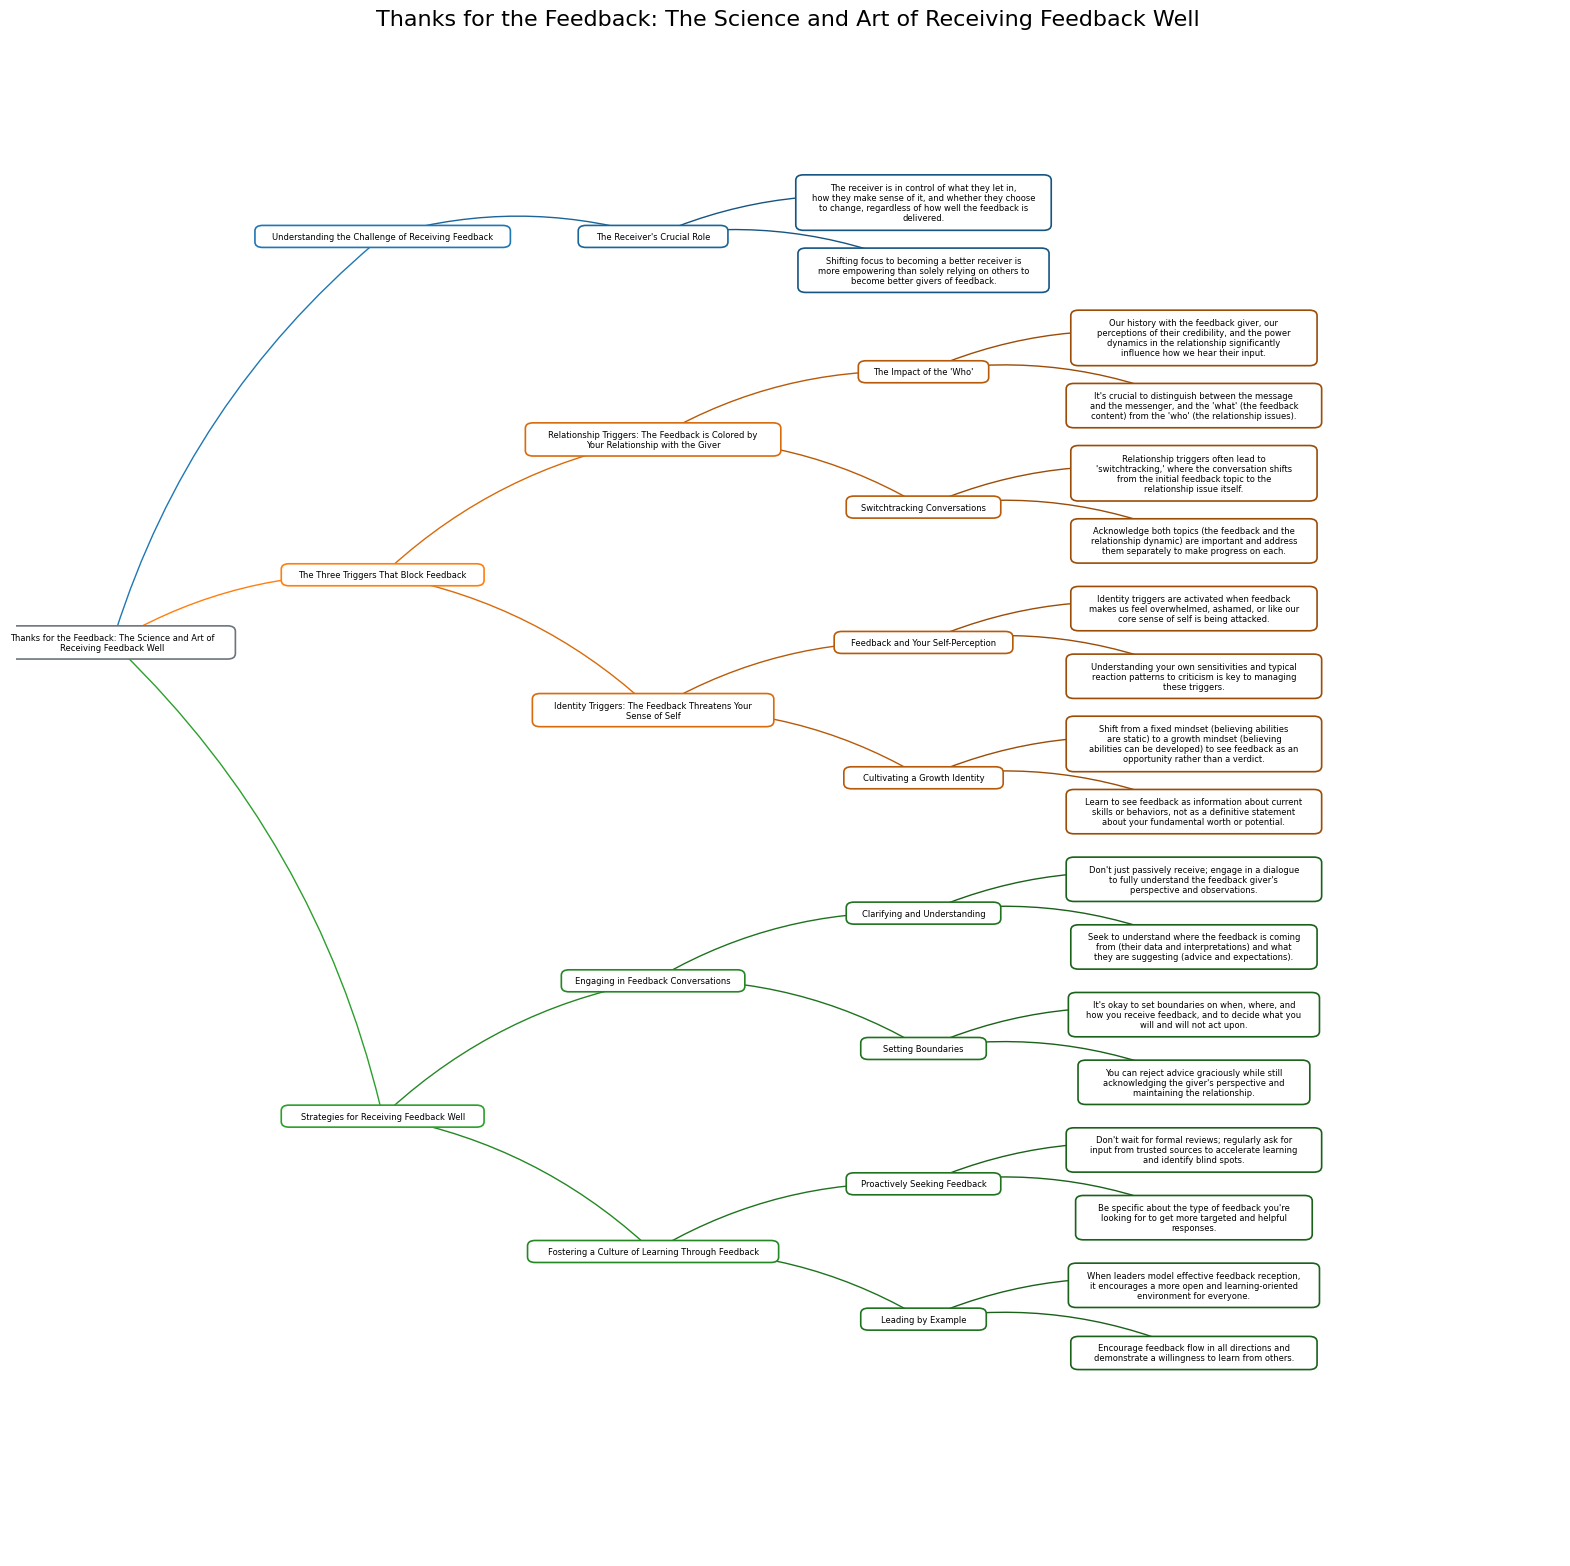

--- Node Position Diagnostics ---
Positioned: A ('Understanding the Challenge of...') at (2.8, 2.0)
MISSING POSITION: B ('The Fundamental Human Dilemma')
MISSING POSITION: B1 ('We inherently desire to learn and grow, which requires feedback, yet we also crave acceptance for who we are now, making feedback feel threatening.')
MISSING POSITION: B2 ('Receiving feedback is not just about the content; it's also about our relationship with the giver and our own identity.')
Positioned: BOOK_ROOT ('Thanks for the Feedback: The S...') at (0.0, 8.0)
Positioned: C ('The Receiver's Crucial Role...') at (5.6, 2.0)
Positioned: C1 ('The receiver is in control of ...') at (8.399999999999999, 1.5)
Positioned: C2 ('Shifting focus to becoming a b...') at (8.399999999999999, 2.5)
Positioned: D ('The Three Triggers That Block ...') at (2.8, 7.0)
MISSING POSITION: E ('Truth Triggers: The Feedback Itself is Perceived as Wrong')
MISSING POSITION: E1 ('Understanding the Types of Feedback')
MISSING POSITION: E1

In [22]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch, FancyBboxPatch
import textwrap

# --- Helper Functions ---
def deepen_hex_color(hex_str, amount=0.85):
    if not hex_str: return '#000000' 
    try:
        if hex_str.startswith('#'):
            hex_str = hex_str[1:]
        rgb = tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))
        deepened_rgb = tuple(min(255, max(0, int(c * amount))) for c in rgb)
        return mcolors.rgb2hex(tuple(c/255.0 for c in deepened_rgb))
    except ValueError:
        return '#000000'

def visualize_mermaid_hierarchy(mermaid_code: str, book_title: str):
    G = nx.DiGraph()
    node_labels = {}
    
    # --- 3. Add Book Title as a new root node ---
    BOOK_ROOT_NODE_ID = "BOOK_ROOT"
    G.add_node(BOOK_ROOT_NODE_ID)
    node_labels[BOOK_ROOT_NODE_ID] = book_title
    
    node_pattern = re.compile(r'(\w+)\["(.+?)"\]')
    edge_pattern = re.compile(r'(\w+)\s*-->\s*(\w+)')

    # Parse original nodes and labels
    for match in node_pattern.finditer(mermaid_code):
        node_id, label = match.groups()
        label = label.strip().lstrip("- ").lstrip("* ")
        node_labels[node_id] = label
        if not G.has_node(node_id):
            G.add_node(node_id)

    # Parse original edges
    for match in edge_pattern.finditer(mermaid_code):
        parent_id, child_id = match.groups()
        if not G.has_node(parent_id): G.add_node(parent_id) 
        if not G.has_node(child_id): G.add_node(child_id)
        G.add_edge(parent_id, child_id)

    # Debug: Check if node E exists in the graph
    print(f"Node E exists in graph: {'E' in G.nodes()}")
    print(f"Node E has edges: {list(G.in_edges('E')) if 'E' in G.nodes() else 'N/A'}")
    print(f"Node E children: {list(G.out_edges('E')) if 'E' in G.nodes() else 'N/A'}")

    # Identify original root nodes (A, D, H) and make them children of BOOK_ROOT_NODE_ID
    original_potential_root_ids = ['A', 'D', 'H'] 
    original_roots_found = []
    for r_id in original_potential_root_ids:
        if r_id in G and G.in_degree(r_id) == 0 : # Check if it's truly a root in the original structure
            original_roots_found.append(r_id)
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
    
    # If A, D, H weren't actual roots (e.g. part of a larger parsed graph unexpectedly)
    # this fallback is less likely needed now with explicit book root.
    if not original_roots_found: # Fallback if specific IDs not found as roots
        temp_original_roots = [n for n in G.nodes() if G.in_degree(n) == 0 and n != BOOK_ROOT_NODE_ID]
        for r_id in temp_original_roots:
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
            original_roots_found.append(r_id)

    # --- Node Depths and Colors ---
    node_depths = {}
    node_colors = {}
    # Color for the new book root
    book_root_color = '#6c757d' # A neutral gray
    
    # Base colors for the main sections (children of book root)
    section_base_colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # The actual root of the entire graph is now BOOK_ROOT_NODE_ID
    graph_root_nodes = [BOOK_ROOT_NODE_ID] 

    # First, ensure every node has a depth and color assigned through complete BFS traversal
    for root_id in graph_root_nodes:
        node_depths[root_id] = 0
        node_colors[root_id] = book_root_color
        
        queue = [(root_id, 0)]  # (node_id, depth)
        head = 0
        
        visited_bfs_color_depth = {root_id}

        while head < len(queue):
            curr_node_id, depth = queue[head]
            head += 1
            
            current_parent_color = node_colors[curr_node_id]
            successors = sorted(list(G.successors(curr_node_id)))
            
            for i, child_id in enumerate(successors):
                if child_id not in visited_bfs_color_depth:
                    visited_bfs_color_depth.add(child_id)
                    new_depth = depth + 1
                    node_depths[child_id] = new_depth
                    
                    if curr_node_id == BOOK_ROOT_NODE_ID: # Children of book root get base section colors
                        node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                    else: # Deeper nodes inherit and deepen
                        node_colors[child_id] = deepen_hex_color(current_parent_color)
                    
                    queue.append((child_id, new_depth))
                # In case a node is visited again via a different path (not in tree), update if shorter depth
                elif node_depths.get(child_id, float('inf')) > depth + 1:
                     node_depths[child_id] = depth + 1
                     # Recolor if path is shorter - depends on desired logic for non-trees
                     if curr_node_id == BOOK_ROOT_NODE_ID:
                         node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                     else:
                         node_colors[child_id] = deepen_hex_color(current_parent_color)
                     # No need to re-add to queue if already processed at a greater or equal depth

    # --- Ensure all nodes in the graph have depths ---
    unprocessed_nodes = [n for n in G.nodes() if n not in node_depths]
    if unprocessed_nodes:
        print(f"Found {len(unprocessed_nodes)} nodes without depths after BFS")
        # For any node that didn't get a depth (shouldn't happen with connected graph),
        # assign based on parent depth
        for node_id in unprocessed_nodes:
            predecessors = list(G.predecessors(node_id))
            if predecessors:
                parent_id = predecessors[0]
                if parent_id in node_depths:
                    node_depths[node_id] = node_depths[parent_id] + 1
                    node_colors[node_id] = deepen_hex_color(node_colors.get(parent_id, '#CCCCCC'))
                else:
                    # If parent also doesn't have depth, assign reasonable defaults
                    node_depths[node_id] = 1  # Arbitrary depth
                    node_colors[node_id] = '#CCCCCC'  # Default color

    # --- Node Positions (Layout) ---
    node_positions = {}
    # Adjusted spacing parameters for request 1 (less padding/overlap)
    horizontal_spacing = 2.8       # Reduced
    vertical_slot_height = 1.0     # Height allocated for a single node's layout slot
    vertical_tree_spacing = 1.5    # Reduced (gap between main branches from book root)
    
    current_tree_base_y = 0.0

    max_overall_depth = 0
    if node_depths:
         max_overall_depth = max(node_depths.values() or [0])
    
    memoized_layout_extents = {} 

    # Debug: Print all nodes in the graph for verification
    print(f"All nodes in graph: {sorted(list(G.nodes()))}")

    # Function to build a complete hierarchy where each node appears only once
    # This is important for the layout algorithm 
    def build_hierarchy_tree():
        # Create a new tree where each node appears once
        hierarchy_tree = nx.DiGraph()
        
        # Start with the book root
        hierarchy_tree.add_node(BOOK_ROOT_NODE_ID)
        
        # Queue for BFS traversal of original graph
        queue = [BOOK_ROOT_NODE_ID]
        visited = {BOOK_ROOT_NODE_ID}
        
        while queue:
            current = queue.pop(0)
            
            # Process children in the original graph
            for child in sorted(G.successors(current)):
                # If this is the first time we're seeing this node in the traversal
                if child not in visited:
                    visited.add(child)
                    # Add to hierarchy tree
                    hierarchy_tree.add_edge(current, child)
                    # Add to queue for further processing
                    queue.append(child)
                # If we've seen this node before, it appears at multiple places in the original graph
                # We don't add it again to the hierarchy tree to avoid cycles
        
        return hierarchy_tree
    
    # Build a clean hierarchy tree for layout
    hierarchy_tree = build_hierarchy_tree()
    
    # Debug: Check which nodes are in the hierarchy tree
    print(f"Nodes in hierarchy tree: {sorted(list(hierarchy_tree.nodes()))}")
    print(f"Node E in hierarchy tree: {'E' in hierarchy_tree.nodes()}")
    
    # Start layout from the actual single root: BOOK_ROOT_NODE_ID
    for processing_root_id in graph_root_nodes: 
        # This recursive function lays out a tree.
        # y_slot_start is the Y coordinate where the current node's allocated slot begins.
        # It returns the Y coordinate where the next SIBLING's slot should begin.
        def layout_subtree(node_id, y_slot_start):
            if node_id in memoized_layout_extents: # Primarily for non-tree graphs; less effect here
                # This logic assumes if a node is re-visited, its subtree bottom is what we need
                return memoized_layout_extents[node_id]['y_max_extent']

            # Get children from the hierarchy tree instead of original graph
            # This ensures we're following a proper tree structure
            children = sorted(list(hierarchy_tree.successors(node_id)))
            node_x = node_depths.get(node_id, 0) * horizontal_spacing
            
            # If it's a leaf node:
            if not children:
                node_y_center = y_slot_start + vertical_slot_height / 2.0
                node_positions[node_id] = (node_x, node_y_center)
                
                memoized_layout_extents[node_id] = {
                    'y_center': node_y_center, 
                    'y_min_extent': y_slot_start, # Top of its slot
                    'y_max_extent': y_slot_start + vertical_slot_height # Bottom of its slot
                }
                return y_slot_start + vertical_slot_height # Next sibling's slot starts after this one

            # If it's a parent node (has children):
            child_centers_y = [] 
            child_min_extents = []
            child_max_extents = []
            
            # child_y_current_slot_start is the Y where the *next* child's slot begins.
            child_y_current_slot_start = y_slot_start 

            for child in children:
                y_after_child_subtree = layout_subtree(child, child_y_current_slot_start)
                
                if child in node_positions and child in memoized_layout_extents:
                    child_centers_y.append(node_positions[child][1]) 
                    child_min_extents.append(memoized_layout_extents[child]['y_min_extent'])
                    child_max_extents.append(memoized_layout_extents[child]['y_max_extent'])
                
                child_y_current_slot_start = y_after_child_subtree # Next child's slot starts where previous ended
            
            parent_y_center = 0
            if child_centers_y: 
                parent_y_center = sum(child_centers_y) / len(child_centers_y)
            else: 
                # If it has children but none were positioned (error or empty G.successors list initially)
                # Place parent at the start of its allocated conceptual slot (though it's not a leaf)
                parent_y_center = y_slot_start + vertical_slot_height / 2.0
            
            node_positions[node_id] = (node_x, parent_y_center)
            
            # Determine the overall vertical extent of this parent's subtree
            # If it has children, its extent is defined by its children's extents.
            # If no children were effectively laid out, its extent is like a single slot.
            overall_min_extent = min(child_min_extents) if child_min_extents else (parent_y_center - vertical_slot_height / 2.0)
            overall_max_extent = max(child_max_extents) if child_max_extents else (parent_y_center + vertical_slot_height / 2.0)
            
            memoized_layout_extents[node_id] = {
                'y_center': parent_y_center, 
                'y_min_extent': overall_min_extent,
                'y_max_extent': overall_max_extent
            }
            return overall_max_extent

        # Initiate layout for the current root's tree
        # (BOOK_ROOT_NODE_ID, and its children A,D,H which are roots of subtrees)
        # The y_slot_start for the absolute root can be 0.
        # Its children will be handled by the recursion.
        tree_y_max_extent = layout_subtree(processing_root_id, current_tree_base_y)
        # current_tree_base_y should not need updating if there's only one absolute root.
        # If multiple disconnected components were drawn, this would space them.
        current_tree_base_y = tree_y_max_extent + vertical_tree_spacing

    if node_positions:
        all_y_coords = [pos[1] for pos in node_positions.values() if pos is not None]
        if all_y_coords:
            min_y_val = min(all_y_coords)
            y_shift = abs(min_y_val) + 0.5 
            
            shifted_node_positions = {}
            for node_id_to_shift, pos_val in node_positions.items():
                if pos_val:
                    x, y = pos_val
                    shifted_node_positions[node_id_to_shift] = (x, y + y_shift)
            node_positions = shifted_node_positions
            current_tree_base_y += y_shift

    # Debug: Check if node E has a position
    print(f"Node E has position: {node_positions.get('E')}")
    
    # Debug: Print nodes that have no positions
    missing_positions = [n for n in G.nodes() if n not in node_positions or node_positions[n] is None]
    print(f"Nodes without positions: {missing_positions}")

    # --- Drawing ---
    max_x_pos = (max_overall_depth + 1) * horizontal_spacing
    max_y_pos = max(10, current_tree_base_y) 

    fig, ax = plt.subplots(figsize=(max(16, max_x_pos / 1.5), max(13, max_y_pos / 1.3 )))
    ax.set_xlim(-1.0, max_x_pos + 1.0) # Adjusted padding
    ax.set_ylim(-1.0, max_y_pos + 1.0) # Adjusted padding
    ax.axis('off')

    # Make sure all nodes in the graph have positions before drawing
    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None:
            # Calculate a position based on parent and apply
            parents = list(G.predecessors(node_id))
            if parents:
                parent_id = parents[0]
                if parent_id in node_positions and node_positions[parent_id] is not None:
                    parent_x, parent_y = node_positions[parent_id]
                    # Position missing node at depth + 1, slightly offset
                    node_depths[node_id] = node_depths.get(parent_id, 0) + 1
                    node_x = node_depths[node_id] * horizontal_spacing
                    # Add a small random offset to y to avoid overlaps
                    import random
                    node_y = parent_y + random.uniform(-0.5, 0.5)
                    node_positions[node_id] = (node_x, node_y)
                    print(f"Fixed position for node {node_id}: {node_positions[node_id]}")
                    # Assign color based on parent
                    node_colors[node_id] = deepen_hex_color(node_colors.get(parent_id, '#CCCCCC'))

    for u, v in G.edges():
        if u not in node_positions or v not in node_positions or node_positions[u] is None or node_positions[v] is None: continue
        pos_u = node_positions[u]
        pos_v = node_positions[v]
        edge_color = node_colors.get(v, 'gray') 
        cp = ConnectionPatch(xyA=pos_v, xyB=pos_u, 
                             coordsA='data', coordsB='data',
                             axesA=ax, axesB=ax,
                             arrowstyle="-", 
                             connectionstyle="arc3,rad=0.15", # Slightly less curve
                             color=edge_color, linewidth=1.0, # Thinner line
                             shrinkA=8, shrinkB=8) # Increased shrink for more gap
        ax.add_patch(cp)

    # Adjusted text and box parameters for request 1
    avg_char_width_approx = 0.05 
    char_height_approx = 0.125 
    min_box_width = 1.2 
    max_box_width_for_wrap = horizontal_spacing * 0.9 # Allow box to use more horiz space
    text_padding = 0.05 # Reduced

    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None: continue
        pos = node_positions[node_id]
        label = node_labels.get(node_id, node_id)
        # Ensure wrap_chars is at least e.g. 15-20 to avoid excessive narrow wrapping.
        wrap_chars = max(30, int(max_box_width_for_wrap / avg_char_width_approx))
        wrapped_label = '\n'.join(textwrap.wrap(label, width=wrap_chars, 
                                                break_long_words=True,
                                                fix_sentence_endings=True))
        num_lines = wrapped_label.count('\n') + 1
        longest_line_len = 0
        if wrapped_label:
             longest_line_len = max(len(s) for s in wrapped_label.split('\n'))
        
        box_width = max(min_box_width, longest_line_len * avg_char_width_approx + 2 * text_padding)
        box_width = min(box_width, max_box_width_for_wrap + text_padding*0.5) # Cap based on available space
        
        # Box height must accommodate text.
        # The layout uses vertical_slot_height conceptually. We try to fit box in it.
        estimated_text_block_height = num_lines * char_height_approx + (num_lines -1) * 0.04 # char_height + interline_spacing
        box_height = estimated_text_block_height + 2 * text_padding
        
        node_color = node_colors.get(node_id, '#CCCCCC') 
        bbox_patch = FancyBboxPatch((pos[0] - box_width / 2, pos[1] - box_height / 2),
                                     box_width, box_height,
                                     boxstyle=f"round,pad={text_padding},rounding_size=0.08", 
                                     ec=node_color, fc='white', lw=1.2) # Thinner border
        ax.add_patch(bbox_patch)
        ax.text(pos[0], pos[1], wrapped_label,
                ha='center', va='center', fontsize=6, color='black', # Further reduced font
                linespacing=1.15) # Reduced linespacing

    plt.title(book_title, fontsize=16) # Generic title for now
    plt.gca().invert_yaxis() 
    plt.tight_layout() # Apply tight_layout before saving

    # Save the figure with higher resolution before showing
    output_filename = f"book-{book_title}.png"
    plt.savefig(output_filename, dpi=200, bbox_inches='tight')
    print(f"High-resolution image saved as {output_filename}")

    plt.show()
    
    # Diagnostic print:
    print("--- Node Position Diagnostics ---")
    for n_id in sorted(G.nodes()):
        if n_id not in node_positions or node_positions[n_id] is None:
            print(f"MISSING POSITION: {n_id} ('{node_labels.get(n_id)}')")
        else:
            print(f"Positioned: {n_id} ('{node_labels.get(n_id, '')[:30]}...') at {node_positions[n_id]}")


# --- Mermaid Code & Book Title ---
book_title_text = "Thanks for the Feedback: The Science and Art of Receiving Feedback Well"
mermaid_input = """
graph TD
    A["Understanding the Challenge of Receiving Feedback"] --> B["The Fundamental Human Dilemma"];
    B --> B1["- We inherently desire to learn and grow, which requires feedback, yet we also crave acceptance for who we are now, making feedback feel threatening."];
    B --> B2["- Receiving feedback is not just about the content; it's also about our relationship with the giver and our own identity."];

    A --> C["The Receiver's Crucial Role"];
    C --> C1["- The receiver is in control of what they let in, how they make sense of it, and whether they choose to change, regardless of how well the feedback is delivered."];
    C --> C2["- Shifting focus to becoming a better receiver is more empowering than solely relying on others to become better givers of feedback."];

    D["The Three Triggers That Block Feedback"] --> E["Truth Triggers: The Feedback Itself is Perceived as Wrong"];
    D --> F["Relationship Triggers: The Feedback is Colored by Your Relationship with the Giver"];
    D --> G["Identity Triggers: The Feedback Threatens Your Sense of Self"];

    E --> E1["Understanding the Types of Feedback"];
    E1 --> E1a["- Feedback can be one of three types: Appreciation (to see, acknowledge, motivate), Coaching (to help improve skills or knowledge), or Evaluation (to rate or rank against standards), and we often want or expect one type but receive another."];
    E1 --> E1b["- Clarify what type of feedback you are getting and what type you are seeking to avoid misunderstandings."];
    E --> E2["Separating the 'What' from the 'Who' and How"];
    E2 --> E2a["- Even if the feedback is poorly delivered or comes from someone you don't entirely trust, try to find the potentially useful information within it."];
    E2 --> E2b["- Challenge your own assumptions and blind spots; seek to understand the giver's perspective even if you don't agree with it."];

    F --> F1["The Impact of the 'Who'"];
    F1 --> F1a["- Our history with the feedback giver, our perceptions of their credibility, and the power dynamics in the relationship significantly influence how we hear their input."];
    F1 --> F1b["- It's crucial to distinguish between the message and the messenger, and the 'what' (the feedback content) from the 'who' (the relationship issues)."];
    F --> F2["Switchtracking Conversations"];
    F2 --> F2a["- Relationship triggers often lead to 'switchtracking,' where the conversation shifts from the initial feedback topic to the relationship issue itself."];
    F2 --> F2b["- Acknowledge both topics (the feedback and the relationship dynamic) are important and address them separately to make progress on each."];

    G --> G1["Feedback and Your Self-Perception"];
    G1 --> G1a["- Identity triggers are activated when feedback makes us feel overwhelmed, ashamed, or like our core sense of self is being attacked."];
    G1 --> G1b["- Understanding your own sensitivities and typical reaction patterns to criticism is key to managing these triggers."];
    G --> G2["Cultivating a Growth Identity"];
    G2 --> G2a["- Shift from a fixed mindset (believing abilities are static) to a growth mindset (believing abilities can be developed) to see feedback as an opportunity rather than a verdict."];
    G2 --> G2b["- Learn to see feedback as information about current skills or behaviors, not as a definitive statement about your fundamental worth or potential."];

    H["Strategies for Receiving Feedback Well"] --> I["Becoming a Skilled Receiver"];
    I --> I1["Managing Your Emotional Responses"];
    I1 --> I1a["- Learn to recognize when you're triggered and create space to process the feedback before reacting defensively."];
    I1 --> I1b["- Practice disarming techniques like asking clarifying questions, paraphrasing to ensure understanding, and taking time to consider the input."];
    I --> I2["Extracting Value"];
    I2 --> I2a["- Actively look for the parts of the feedback that might be true or useful, even if other parts seem off-base."];
    I2 --> I2b["- Ask for specific examples and suggestions for improvement to make the feedback more actionable."];

    H --> J["Engaging in Feedback Conversations"];
    J --> J1["Clarifying and Understanding"];
    J1 --> J1a["- Don't just passively receive; engage in a dialogue to fully understand the feedback giver's perspective and observations."];
    J1 --> J1b["- Seek to understand where the feedback is coming from (their data and interpretations) and what they are suggesting (advice and expectations)."];
    J --> J2["Setting Boundaries"];
    J2 --> J2a["- It's okay to set boundaries on when, where, and how you receive feedback, and to decide what you will and will not act upon."];
    J2 --> J2b["- You can reject advice graciously while still acknowledging the giver's perspective and maintaining the relationship."];

    H --> K["Fostering a Culture of Learning Through Feedback"];
    K --> K1["Proactively Seeking Feedback"];
    K1 --> K1a["- Don't wait for formal reviews; regularly ask for input from trusted sources to accelerate learning and identify blind spots."];
    K1 --> K1b["- Be specific about the type of feedback you're looking for to get more targeted and helpful responses."];
    K --> K2["Leading by Example"];
    K2 --> K2a["- When leaders model effective feedback reception, it encourages a more open and learning-oriented environment for everyone."];
    K2 --> K2b["- Encourage feedback flow in all directions and demonstrate a willingness to learn from others."];
"""

if __name__ == '__main__':
    visualize_mermaid_hierarchy(mermaid_input, book_title_text)

In [28]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch, FancyBboxPatch
import textwrap

# --- Helper Functions ---
def deepen_hex_color(hex_str, amount=0.85):
    if not hex_str: return '#000000' 
    try:
        if hex_str.startswith('#'):
            hex_str = hex_str[1:]
        rgb = tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))
        deepened_rgb = tuple(min(255, max(0, int(c * amount))) for c in rgb)
        return mcolors.rgb2hex(tuple(c/255.0 for c in deepened_rgb))
    except ValueError:
        return '#000000'

def visualize_mermaid_hierarchy(mermaid_code: str, book_title: str):
    G = nx.DiGraph()
    node_labels = {}
    
    # --- 3. Add Book Title as a new root node ---
    BOOK_ROOT_NODE_ID = "BOOK_ROOT"
    G.add_node(BOOK_ROOT_NODE_ID)
    node_labels[BOOK_ROOT_NODE_ID] = book_title
    
    node_pattern = re.compile(r'(\w+)\["(.+?)"\]')
    edge_pattern = re.compile(r'(\w+)\s*-->\s*(\w+)')

    # Parse original nodes and labels
    for match in node_pattern.finditer(mermaid_code):
        node_id, label = match.groups()
        label = label.strip().lstrip("- ").lstrip("* ")
        node_labels[node_id] = label
        if not G.has_node(node_id):
            G.add_node(node_id)

    # Parse original edges
    # -------------------------------------------------------------
    # When an edge is declared in Mermaid like:
    #     A["Some label"] --> B["Another label"];
    # naive regexes that look directly for "A --> B" will fail because
    # the text between the node-ID (A) and the arrow ("-->") contains a
    # label definition in square brackets.  To avoid accidentally
    # capturing the last word of the label as the parent ID, we first
    # strip out every  ["…"]  label segment.  This leaves us with plain
    #   A --> B
    # lines that the simple edge pattern can parse reliably.
    # -------------------------------------------------------------
    code_without_labels = re.sub(r'\[".*?"\]', '', mermaid_code)

    for match in edge_pattern.finditer(code_without_labels):
        parent_id, child_id = match.groups()
        if not G.has_node(parent_id):
            G.add_node(parent_id)
        if not G.has_node(child_id):
            G.add_node(child_id)
        G.add_edge(parent_id, child_id)

    # Debug: Check if node E exists in the graph
    print(f"Node E exists in graph: {'E' in G.nodes()}")
    print(f"Node E has edges: {list(G.in_edges('E')) if 'E' in G.nodes() else 'N/A'}")
    print(f"Node E children: {list(G.out_edges('E')) if 'E' in G.nodes() else 'N/A'}")

    # Identify original root nodes (A, D, H) and make them children of BOOK_ROOT_NODE_ID
    original_potential_root_ids = ['A', 'D', 'H'] 
    original_roots_found = []
    for r_id in original_potential_root_ids:
        if r_id in G and G.in_degree(r_id) == 0 : # Check if it's truly a root in the original structure
            original_roots_found.append(r_id)
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
    
    # If A, D, H weren't actual roots (e.g. part of a larger parsed graph unexpectedly)
    # this fallback is less likely needed now with explicit book root.
    if not original_roots_found: # Fallback if specific IDs not found as roots
        temp_original_roots = [n for n in G.nodes() if G.in_degree(n) == 0 and n != BOOK_ROOT_NODE_ID]
        for r_id in temp_original_roots:
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
            original_roots_found.append(r_id)

    # -------------------------------------------------------------
    # EXTRA SAFETY: After the steps above, there may still be "orphan"
    # roots that were not in the hard-coded list (e.g. B, C, E, F, G).
    # Connect **any** remaining zero-in-degree nodes to BOOK_ROOT so the
    # layout routine will visit them and assign positions.
    # -------------------------------------------------------------
    remaining_orphan_roots = [n for n in G.nodes() if n != BOOK_ROOT_NODE_ID and G.in_degree(n) == 0]
    for orphan_id in remaining_orphan_roots:
        if not G.has_edge(BOOK_ROOT_NODE_ID, orphan_id):
            G.add_edge(BOOK_ROOT_NODE_ID, orphan_id)

    # --- Node Depths and Colors ---
    node_depths = {}
    node_colors = {}
    # Color for the new book root
    book_root_color = '#6c757d' # A neutral gray
    
    # Base colors for the main sections (children of book root)
    section_base_colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # The actual root of the entire graph is now BOOK_ROOT_NODE_ID
    graph_root_nodes = [BOOK_ROOT_NODE_ID] 

    for root_id in graph_root_nodes: # Should only be BOOK_ROOT_NODE_ID
        node_depths[root_id] = 0
        node_colors[root_id] = book_root_color
        
        queue = [(root_id, 0)]  # (node_id, depth)
        head = 0
        
        visited_bfs_color_depth = {root_id}

        while head < len(queue):
            curr_node_id, depth = queue[head]
            head += 1
            
            current_parent_color = node_colors[curr_node_id]
            successors = sorted(list(G.successors(curr_node_id)))
            
            for i, child_id in enumerate(successors):
                if child_id not in visited_bfs_color_depth:
                    visited_bfs_color_depth.add(child_id)
                    new_depth = depth + 1
                    node_depths[child_id] = new_depth
                    
                    if curr_node_id == BOOK_ROOT_NODE_ID: # Children of book root get base section colors
                        node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                    else: # Deeper nodes inherit and deepen
                        node_colors[child_id] = deepen_hex_color(current_parent_color)
                    
                    queue.append((child_id, new_depth))
                # In case a node is visited again via a different path (not in tree), update if shorter depth
                elif node_depths.get(child_id, float('inf')) > depth + 1:
                     node_depths[child_id] = depth + 1
                     # Recolor if path is shorter - depends on desired logic for non-trees
                     if curr_node_id == BOOK_ROOT_NODE_ID:
                         node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                     else:
                         node_colors[child_id] = deepen_hex_color(current_parent_color)
                     # No need to re-add to queue if already processed at a greater or equal depth

    # --- Node Positions (Layout) ---
    node_positions = {}
    # Adjusted spacing parameters for request 1 (less padding/overlap)
    horizontal_spacing = 2.8       # Reduced
    vertical_slot_height = 1.0     # Height allocated for a single node's layout slot
    vertical_tree_spacing = 1.5    # Reduced (gap between main branches from book root)
    
    current_tree_base_y = 0.0

    max_overall_depth = 0
    if node_depths:
         max_overall_depth = max(node_depths.values() or [0])
    
    memoized_layout_extents = {} 

    # Debug: Print all nodes in the graph for verification
    print(f"All nodes in graph: {sorted(list(G.nodes()))}")

    # Start layout from the actual single root: BOOK_ROOT_NODE_ID
    for processing_root_id in graph_root_nodes: 
        # This recursive function lays out a tree.
        # y_slot_start is the Y coordinate where the current node's allocated slot begins.
        # It returns the Y coordinate where the next SIBLING's slot should begin.
        def layout_subtree(node_id, y_slot_start):
            if node_id in memoized_layout_extents: # Primarily for non-tree graphs; less effect here
                # This logic assumes if a node is re-visited, its subtree bottom is what we need
                return memoized_layout_extents[node_id]['y_max_extent']

            children = sorted(list(G.successors(node_id)))
            node_x = node_depths.get(node_id, 0) * horizontal_spacing
            
            # If it's a leaf node:
            if not children:
                node_y_center = y_slot_start + vertical_slot_height / 2.0
                node_positions[node_id] = (node_x, node_y_center)
                
                memoized_layout_extents[node_id] = {
                    'y_center': node_y_center, 
                    'y_min_extent': y_slot_start, # Top of its slot
                    'y_max_extent': y_slot_start + vertical_slot_height # Bottom of its slot
                }
                return y_slot_start + vertical_slot_height # Next sibling's slot starts after this one

            # If it's a parent node (has children):
            child_centers_y = [] 
            child_min_extents = []
            child_max_extents = []
            
            # child_y_current_slot_start is the Y where the *next* child's slot begins.
            child_y_current_slot_start = y_slot_start 

            for child in children:
                y_after_child_subtree = layout_subtree(child, child_y_current_slot_start)
                
                if child in node_positions and child in memoized_layout_extents:
                    child_centers_y.append(node_positions[child][1]) 
                    child_min_extents.append(memoized_layout_extents[child]['y_min_extent'])
                    child_max_extents.append(memoized_layout_extents[child]['y_max_extent'])
                
                child_y_current_slot_start = y_after_child_subtree # Next child's slot starts where previous ended
            
            parent_y_center = 0
            if child_centers_y: 
                parent_y_center = sum(child_centers_y) / len(child_centers_y)
            else: 
                # If it has children but none were positioned (error or empty G.successors list initially)
                # Place parent at the start of its allocated conceptual slot (though it's not a leaf)
                parent_y_center = y_slot_start + vertical_slot_height / 2.0
            
            node_positions[node_id] = (node_x, parent_y_center)
            
            # Determine the overall vertical extent of this parent's subtree
            # If it has children, its extent is defined by its children's extents.
            # If no children were effectively laid out, its extent is like a single slot.
            overall_min_extent = min(child_min_extents) if child_min_extents else (parent_y_center - vertical_slot_height / 2.0)
            overall_max_extent = max(child_max_extents) if child_max_extents else (parent_y_center + vertical_slot_height / 2.0)
            
            memoized_layout_extents[node_id] = {
                'y_center': parent_y_center, 
                'y_min_extent': overall_min_extent,
                'y_max_extent': overall_max_extent
            }
            return overall_max_extent

        # Initiate layout for the current root's tree
        # (BOOK_ROOT_NODE_ID, and its children A,D,H which are roots of subtrees)
        # The y_slot_start for the absolute root can be 0.
        # Its children will be handled by the recursion.
        tree_y_max_extent = layout_subtree(processing_root_id, current_tree_base_y)
        # current_tree_base_y should not need updating if there's only one absolute root.
        # If multiple disconnected components were drawn, this would space them.
        current_tree_base_y = tree_y_max_extent + vertical_tree_spacing


    if node_positions:
        all_y_coords = [pos[1] for pos in node_positions.values() if pos is not None]
        if all_y_coords:
            min_y_val = min(all_y_coords)
            y_shift = abs(min_y_val) + 0.5 
            
            shifted_node_positions = {}
            for node_id_to_shift, pos_val in node_positions.items():
                if pos_val:
                    x, y = pos_val
                    shifted_node_positions[node_id_to_shift] = (x, y + y_shift)
            node_positions = shifted_node_positions
            current_tree_base_y += y_shift

    # Debug: Check if node E has a position
    print(f"Node E has position: {node_positions.get('E')}")
    
    # Debug: Print nodes that have no positions
    missing_positions = [n for n in G.nodes() if n not in node_positions or node_positions[n] is None]
    print(f"Nodes without positions: {missing_positions}")

    # --- Drawing ---
    max_x_pos = (max_overall_depth + 1) * horizontal_spacing
    max_y_pos = max(10, current_tree_base_y) 

    fig, ax = plt.subplots(figsize=(max(16, max_x_pos / 1.5), max(13, max_y_pos / 1.3 )))
    ax.set_xlim(-1.0, max_x_pos + 1.0) # Adjusted padding
    ax.set_ylim(-1.0, max_y_pos + 1.0) # Adjusted padding
    ax.axis('off')

    # Make sure all nodes in the graph have positions before drawing
    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None:
            # Calculate a position based on parent and apply
            parents = list(G.predecessors(node_id))
            if parents:
                parent_id = parents[0]
                if parent_id in node_positions and node_positions[parent_id] is not None:
                    parent_x, parent_y = node_positions[parent_id]
                    # Position missing node at depth + 1, slightly offset
                    node_depths[node_id] = node_depths.get(parent_id, 0) + 1
                    node_x = node_depths[node_id] * horizontal_spacing
                    # Add a small random offset to y to avoid overlaps
                    import random
                    node_y = parent_y + random.uniform(-0.5, 0.5)
                    node_positions[node_id] = (node_x, node_y)
                    print(f"Fixed position for node {node_id}: {node_positions[node_id]}")
                    # Assign color based on parent
                    node_colors[node_id] = deepen_hex_color(node_colors.get(parent_id, '#CCCCCC'))

    for u, v in G.edges():
        if u not in node_positions or v not in node_positions or node_positions[u] is None or node_positions[v] is None: continue
        pos_u = node_positions[u]
        pos_v = node_positions[v]
        edge_color = node_colors.get(v, 'gray') 
        cp = ConnectionPatch(xyA=pos_v, xyB=pos_u, 
                             coordsA='data', coordsB='data',
                             axesA=ax, axesB=ax,
                             arrowstyle="-", 
                             connectionstyle="arc3,rad=0.15", # Slightly less curve
                             color=edge_color, linewidth=1.0, # Thinner line
                             shrinkA=8, shrinkB=8) # Increased shrink for more gap
        ax.add_patch(cp)

    # Adjusted text and box parameters for request 1
    avg_char_width_approx = 0.05 
    char_height_approx = 0.125 
    min_box_width = 1.2 
    max_box_width_for_wrap = horizontal_spacing * 0.9 # Allow box to use more horiz space
    text_padding = 0.05 # Reduced

    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None: continue
        pos = node_positions[node_id]
        label = node_labels.get(node_id, node_id)
        # Ensure wrap_chars is at least e.g. 15-20 to avoid excessive narrow wrapping.
        wrap_chars = max(30, int(max_box_width_for_wrap / avg_char_width_approx))
        wrapped_label = '\n'.join(textwrap.wrap(label, width=wrap_chars, 
                                                break_long_words=True,
                                                fix_sentence_endings=True))
        num_lines = wrapped_label.count('\n') + 1
        longest_line_len = 0
        if wrapped_label:
             longest_line_len = max(len(s) for s in wrapped_label.split('\n'))
        
        box_width = max(min_box_width, longest_line_len * avg_char_width_approx + 2 * text_padding)
        box_width = min(box_width, max_box_width_for_wrap + text_padding*0.5) # Cap based on available space
        
        # Box height must accommodate text.
        # The layout uses vertical_slot_height conceptually. We try to fit box in it.
        estimated_text_block_height = num_lines * char_height_approx + (num_lines -1) * 0.04 # char_height + interline_spacing
        box_height = estimated_text_block_height + 2 * text_padding
        
        node_color = node_colors.get(node_id, '#CCCCCC') 
        bbox_patch = FancyBboxPatch((pos[0] - box_width / 2, pos[1] - box_height / 2),
                                     box_width, box_height,
                                     boxstyle=f"round,pad={text_padding},rounding_size=0.08", 
                                     ec=node_color, fc='white', lw=1.2) # Thinner border
        ax.add_patch(bbox_patch)
        ax.text(pos[0], pos[1], wrapped_label,
                ha='center', va='center', fontsize=6, color='black', # Further reduced font
                linespacing=1.15) # Reduced linespacing

    plt.title(book_title, fontsize=16) # Generic title for now
    plt.gca().invert_yaxis() 
    plt.tight_layout() # Apply tight_layout before saving

    # Save the figure with higher resolution before showing
    output_filename = f"book-{book_title}.png"
    plt.savefig(output_filename, dpi=200, bbox_inches='tight')
    print(f"High-resolution image saved as {output_filename}")

    plt.show()
    
    # Diagnostic print:
    print("--- Node Position Diagnostics ---")
    for n_id in sorted(G.nodes()):
        if n_id not in node_positions or node_positions[n_id] is None:
            print(f"MISSING POSITION: {n_id} ('{node_labels.get(n_id)}')")
        else:
            print(f"Positioned: {n_id} ('{node_labels.get(n_id, '')[:30]}...') at {node_positions[n_id]}")


Node E exists in graph: True
Node E has edges: []
Node E children: [('E', 'E1'), ('E', 'E2'), ('E', 'E3')]
All nodes in graph: ['A', 'A1', 'A1a', 'A1b', 'A1c', 'A2', 'A2a', 'A2b', 'A2c', 'B', 'B1', 'B1a', 'B1b', 'B1c', 'B2', 'B2a', 'B2b', 'B2c', 'B3', 'B3a', 'B3b', 'B3c', 'BOOK_ROOT', 'C', 'C1', 'C1a', 'C1b', 'C1c', 'C2', 'C2a', 'C2b', 'C2c', 'C3', 'C3a', 'C3b', 'C3c', 'D', 'D1', 'D1a', 'D1b', 'D1c', 'D2', 'D2a', 'D2b', 'D2c', 'E', 'E1', 'E1a', 'E1b', 'E1c', 'E2', 'E2a', 'E2b', 'E2c', 'E3', 'E3a', 'E3b', 'F', 'F1', 'F1a', 'F1b', 'F1c', 'F2', 'F2a', 'F2b', 'F2c', 'F3', 'F3a', 'F3b', 'G', 'G1', 'G1a', 'G1b', 'G1c', 'G2', 'G2a', 'G2b', 'G2c']
Node E has position: (2.8, 35.333333333333336)
Nodes without positions: []
High-resolution image saved as book-Amp It Up: Core Principles for Hypergrowth.png


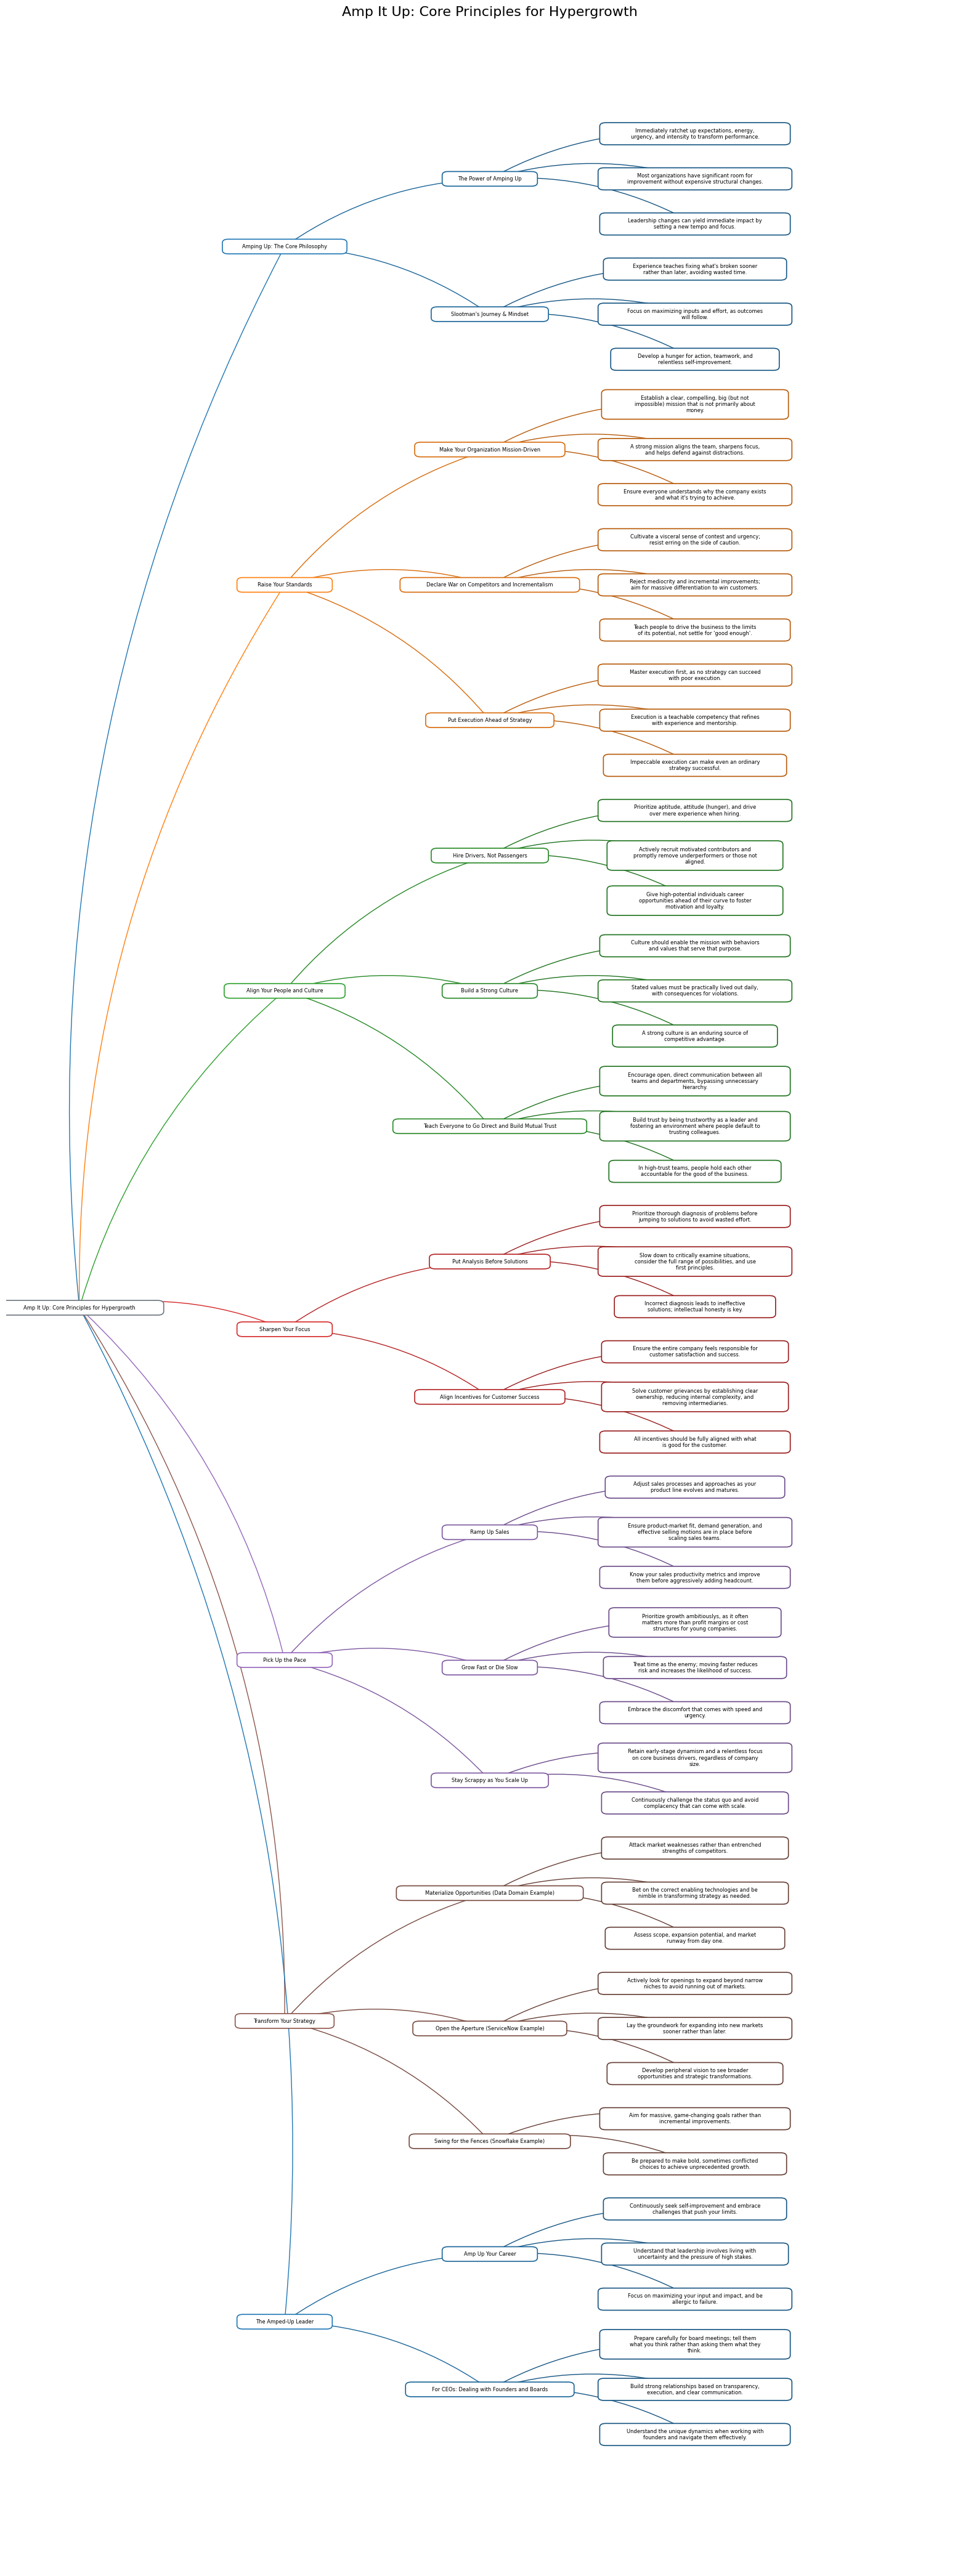

--- Node Position Diagnostics ---
Positioned: A ('Amping Up: The Core Philosophy...') at (2.8, 4.0)
Positioned: A1 ('The Power of Amping Up...') at (5.6, 2.5)
Positioned: A1a ('Immediately ratchet up expecta...') at (8.399999999999999, 1.5)
Positioned: A1b ('Most organizations have signif...') at (8.399999999999999, 2.5)
Positioned: A1c ('Leadership changes can yield i...') at (8.399999999999999, 3.5)
Positioned: A2 ('Slootman's Journey & Mindset...') at (5.6, 5.5)
Positioned: A2a ('Experience teaches fixing what...') at (8.399999999999999, 4.5)
Positioned: A2b ('Focus on maximizing inputs and...') at (8.399999999999999, 5.5)
Positioned: A2c ('Develop a hunger for action, t...') at (8.399999999999999, 6.5)
Positioned: B ('Raise Your Standards...') at (2.8, 11.5)
Positioned: B1 ('Make Your Organization Mission...') at (5.6, 8.5)
Positioned: B1a ('Establish a clear, compelling,...') at (8.399999999999999, 7.5)
Positioned: B1b ('A strong mission aligns the te...') at (8.399999999999999, 8

In [29]:

# --- Mermaid Code & Book Title ---
book_title_text = "Amp It Up: Core Principles for Hypergrowth"
mermaid_input = """
graph TD
    A["Amping Up: The Core Philosophy"] --> A1["The Power of Amping Up"];
    A1 --> A1a["- Immediately ratchet up expectations, energy, urgency, and intensity to transform performance."];
    A1 --> A1b["- Most organizations have significant room for improvement without expensive structural changes."];
    A1 --> A1c["- Leadership changes can yield immediate impact by setting a new tempo and focus."];

    A --> A2["Slootman's Journey & Mindset"];
    A2 --> A2a["- Experience teaches fixing what's broken sooner rather than later, avoiding wasted time."];
    A2 --> A2b["- Focus on maximizing inputs and effort, as outcomes will follow."];
    A2 --> A2c["- Develop a hunger for action, teamwork, and relentless self-improvement."];

    B["Raise Your Standards"] --> B1["Make Your Organization Mission-Driven"];
    B1 --> B1a["- Establish a clear, compelling, big (but not impossible) mission that is not primarily about money."];
    B1 --> B1b["- A strong mission aligns the team, sharpens focus, and helps defend against distractions."];
    B1 --> B1c["- Ensure everyone understands why the company exists and what it's trying to achieve."];

    B --> B2["Declare War on Competitors and Incrementalism"];
    B2 --> B2a["- Cultivate a visceral sense of contest and urgency; resist erring on the side of caution."];
    B2 --> B2b["- Reject mediocrity and incremental improvements; aim for massive differentiation to win customers."];
    B2 --> B2c["- Teach people to drive the business to the limits of its potential, not settle for 'good enough'."];

    B --> B3["Put Execution Ahead of Strategy"];
    B3 --> B3a["- Master execution first, as no strategy can succeed with poor execution."];
    B3 --> B3b["- Execution is a teachable competency that refines with experience and mentorship."];
    B3 --> B3c["- Impeccable execution can make even an ordinary strategy successful."];

    C["Align Your People and Culture"] --> C1["Hire Drivers, Not Passengers"];
    C1 --> C1a["- Prioritize aptitude, attitude (hunger), and drive over mere experience when hiring."];
    C1 --> C1b["- Actively recruit motivated contributors and promptly remove underperformers or those not aligned."];
    C1 --> C1c["- Give high-potential individuals career opportunities ahead of their curve to foster motivation and loyalty."];

    C --> C2["Build a Strong Culture"];
    C2 --> C2a["- Culture should enable the mission with behaviors and values that serve that purpose."];
    C2 --> C2b["- Stated values must be practically lived out daily, with consequences for violations."];
    C2 --> C2c["- A strong culture is an enduring source of competitive advantage."];

    C --> C3["Teach Everyone to Go Direct and Build Mutual Trust"];
    C3 --> C3a["- Encourage open, direct communication between all teams and departments, bypassing unnecessary hierarchy."];
    C3 --> C3b["- Build trust by being trustworthy as a leader and fostering an environment where people default to trusting colleagues."];
    C3 --> C3c["- In high-trust teams, people hold each other accountable for the good of the business."];

    D["Sharpen Your Focus"] --> D1["Put Analysis Before Solutions"];
    D1 --> D1a["- Prioritize thorough diagnosis of problems before jumping to solutions to avoid wasted effort."];
    D1 --> D1b["- Slow down to critically examine situations, consider the full range of possibilities, and use first principles."];
    D1 --> D1c["- Incorrect diagnosis leads to ineffective solutions; intellectual honesty is key."];

    D --> D2["Align Incentives for Customer Success"];
    D2 --> D2a["- Ensure the entire company feels responsible for customer satisfaction and success."];
    D2 --> D2b["- Solve customer grievances by establishing clear ownership, reducing internal complexity, and removing intermediaries."];
    D2 --> D2c["- All incentives should be fully aligned with what is good for the customer."];

    E["Pick Up the Pace"] --> E1["Ramp Up Sales"];
    E1 --> E1a["- Adjust sales processes and approaches as your product line evolves and matures."];
    E1 --> E1b["- Ensure product-market fit, demand generation, and effective selling motions are in place before scaling sales teams."];
    E1 --> E1c["- Know your sales productivity metrics and improve them before aggressively adding headcount."];

    E --> E2["Grow Fast or Die Slow"];
    E2 --> E2a["- Prioritize growth ambitiouslys, as it often matters more than profit margins or cost structures for young companies."];
    E2 --> E2b["- Treat time as the enemy; moving faster reduces risk and increases the likelihood of success."];
    E2 --> E2c["- Embrace the discomfort that comes with speed and urgency."];

    E --> E3["Stay Scrappy as You Scale Up"];
    E3 --> E3a["- Retain early-stage dynamism and a relentless focus on core business drivers, regardless of company size."];
    E3 --> E3b["- Continuously challenge the status quo and avoid complacency that can come with scale."];

    F["Transform Your Strategy"] --> F1["Materialize Opportunities (Data Domain Example)"];
    F1 --> F1a["- Attack market weaknesses rather than entrenched strengths of competitors."];
    F1 --> F1b["- Bet on the correct enabling technologies and be nimble in transforming strategy as needed."];
    F1 --> F1c["- Assess scope, expansion potential, and market runway from day one."];

    F --> F2["Open the Aperture (ServiceNow Example)"];
    F2 --> F2a["- Actively look for openings to expand beyond narrow niches to avoid running out of markets."];
    F2 --> F2b["- Lay the groundwork for expanding into new markets sooner rather than later."];
    F2 --> F2c["- Develop peripheral vision to see broader opportunities and strategic transformations."];

    F --> F3["Swing for the Fences (Snowflake Example)"];
    F3 --> F3a["- Aim for massive, game-changing goals rather than incremental improvements."];
    F3 --> F3b["- Be prepared to make bold, sometimes conflicted choices to achieve unprecedented growth."];

    G["The Amped-Up Leader"] --> G1["Amp Up Your Career"];
    G1 --> G1a["- Continuously seek self-improvement and embrace challenges that push your limits."];
    G1 --> G1b["- Understand that leadership involves living with uncertainty and the pressure of high stakes."];
    G1 --> G1c["- Focus on maximizing your input and impact, and be allergic to failure."];

    G --> G2["For CEOs: Dealing with Founders and Boards"];
    G2 --> G2a["- Prepare carefully for board meetings; tell them what you think rather than asking them what they think."];
    G2 --> G2b["- Build strong relationships based on transparency, execution, and clear communication."];
    G2 --> G2c["- Understand the unique dynamics when working with founders and navigate them effectively."];
"""

if __name__ == '__main__':
    visualize_mermaid_hierarchy(mermaid_input, book_title_text)